$\textbf{Selection of Depth and Areal Regions}$

$\text{In this tutorial we will see how to select the best region in the dataset using the PyCCAPT calibration module.}$

In [1]:
# Activate intractive functionality of matplotlib
%matplotlib notebook
# import libraries
import os
import os.path as path
import matplotlib.pyplot as plt

# Local module and scripts
from pyccapt.calibration.calibration_tools import variables, data_loadcrop, tools
from pyccapt.calibration.calibration_tools import widgets as wd

In [2]:
# if recieve error for pytables library you should uncomment the line below and run the cell
import sys
# !conda install --yes --prefix {sys.prefix} pytables

In [3]:
# dataset name
# AL_data_b
# OLO_AL_6_data
# OLO_W_6_data
# OLO_Ni_8_data
# X6Cr17_2V30Min_5_data
# data_1029_Jun-27-2022_15-53_Pd
# data_115_Jul-27-2022_17-44_Powersweep3
# SS-420-1_data
# data_1029_Jun-27-2022_15-53_Pd

In [4]:
tdc, pulse_mode, dataset, flightPathLength_d, t0_d = wd.dataset_tdc_selection()
display(tdc, pulse_mode, dataset, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

Text(value='OLO_AL_6_data', description='Dataset:', placeholder='Paste ticket description here!')

Text(value='110', description='Flight path length:', placeholder='Flight path length')

Text(value='51.74', description='t0:', placeholder='T_0 of the instrument')

$\text{Path to the dataset}$

In [6]:
tdc_model = tdc.value
pulse_mode_ini = pulse_mode.value

dataset_name = dataset.value

flightPathLength = float(flightPathLength_d.value) # mm 
# The initial value for t_0
t0 = float(t0_d.value) # ns

p = path.abspath(path.join("", "../../../.."))

variables.init()
variables.path = os.path.join(p, 'tests//data')
variables.result_path = os.path.join(p, 'tests/results/load_crop/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
# dataset name
filename = variables.path + '//' + dataset_name + '.h5'
savename = variables.result_path + '//' + dataset_name + '_cropped' + '.h5'

# Create data farame out of hdf5 file dataset
dldGroupStorage = data_loadcrop.fetch_dataset_from_dld_grp(filename, tdc=tdc_model, pulse_mode=pulse_mode_ini)
dld_masterDataframe = data_loadcrop.concatenate_dataframes_of_dld_grp(dldGroupStorage)
print('Total number of Ions:', len(dldGroupStorage[0]))

Filename>> C:\Users\mehrp\PycharmProjects\pyccapt\tests//data//OLO_AL_6_data.h5
{'cropped_dld': ['high_voltage', 'pulse_voltage', 'start_counter', 't', 'x', 'y'], 'dld': ['high_voltage', 'pulse_voltage', 'start_counter', 't', 'x', 'y'], 'oxcart': ['high_voltage', 'main_chamber_vacuum', 'num_events', 'pulse_voltage', 'temperature', 'time_counter'], 'tdc': ['channel', 'high_voltage', 'pulse_voltage', 'start_counter', 'time_data'], 'time': ['time_h', 'time_m', 'time_s']}
Total number of Ions: 2000206


$\textbf {Crop and select the stable projection(right side) of below plotted graph}$
<br>
<br>
$\text{In the Experiment history plot below you should select the ions. After selectiong the ions with a rectangle you can continue and run the next cell. }$

<IPython.core.display.Javascript object>


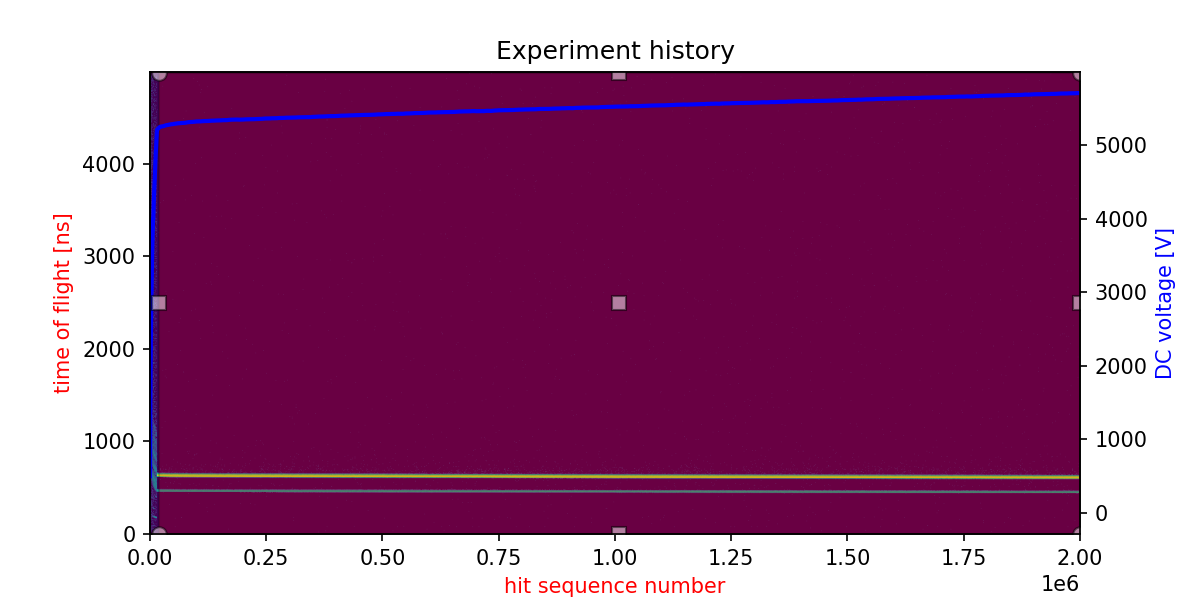

In [8]:
fig1, ax1 = plt.subplots(figsize=(8, 4))
data_loadcrop.plot_graph_for_dld_high_voltage(ax1, dldGroupStorage, save_name = variables.result_path + '//ex_hist_' + dataset_name)



$\text{Boundaries of the selected(cropped) part of the graph is printed below}$

In [9]:
# Crop the dataset
print('Min Idx:', variables.selected_x1, 'Max Idx:', variables.selected_x2)
data_crop = data_loadcrop.crop_dataset(dld_masterDataframe)

Min Idx: 18684.57941362937 Max Idx: 1999532.7568329845


<IPython.core.display.Javascript object>


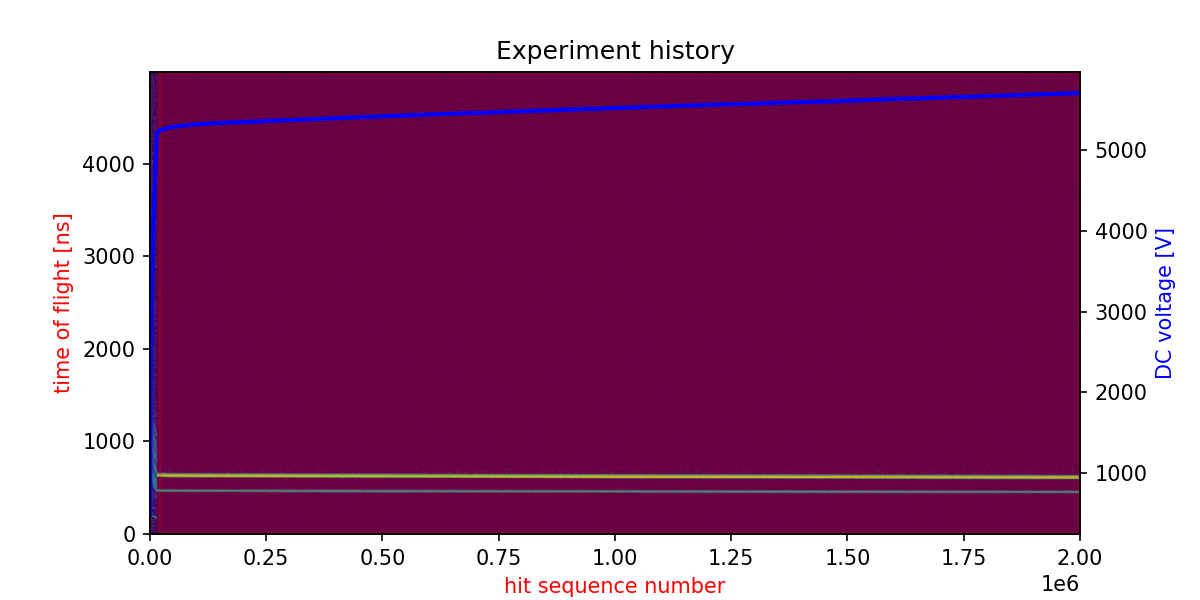

In [10]:
# Plot and selected experiment history
fig1, ax1 = plt.subplots(figsize=(8, 4))
data_loadcrop.plot_graph_for_dld_high_voltage(ax1, dldGroupStorage, rect=True, save_name=variables.result_path + '//ex_hist_slected_' + dataset_name)

$\textbf {ROI selcetion}$
<br>
<br>
$\text {Select the region of maximum concentration of electrons in the below plotted graph to utlize relevant data}$

<IPython.core.display.Javascript object>


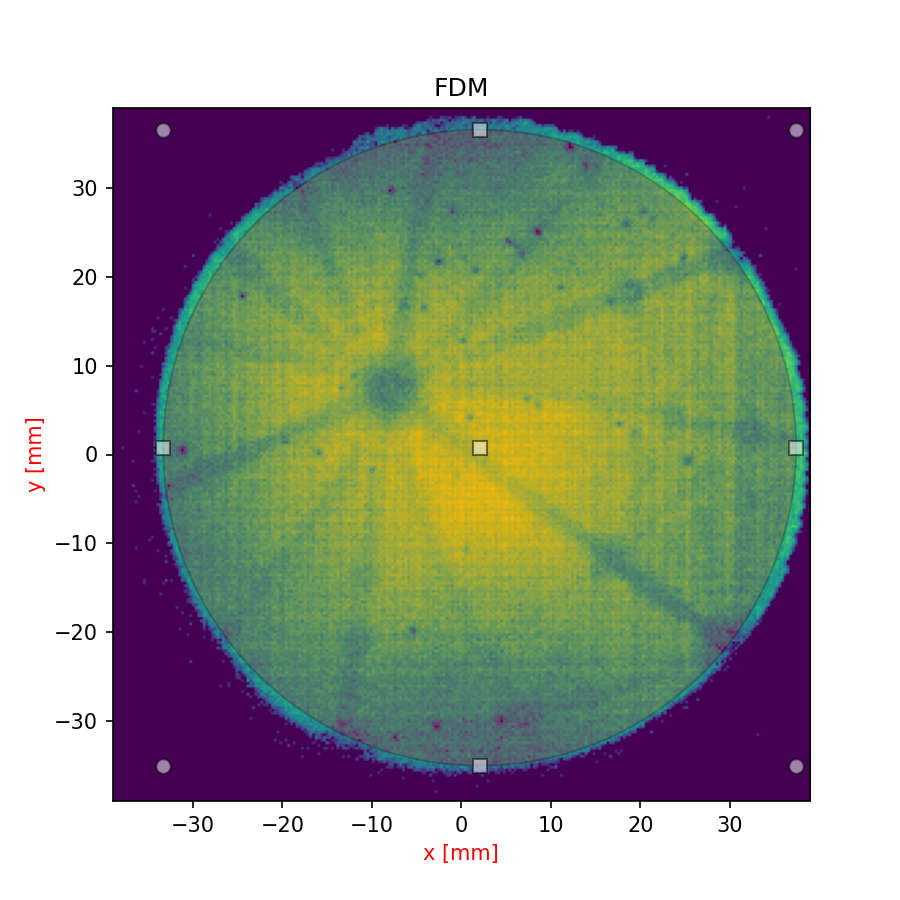

10-20-2022 12:59:51 | INFO | Plot saved by the name C:\Users\mehrp\PycharmProjects\pyccapt\tests/results/load_crop/OLO_AL_6_data//FDM_OLO_AL_6_data
10-20-2022 12:59:51 | INFO | Plot saved by the name C:\Users\mehrp\PycharmProjects\pyccapt\tests/results/load_crop/OLO_AL_6_data//FDM_OLO_AL_6_data
10-20-2022 12:59:51 | INFO | Plot saved by the name C:\Users\mehrp\PycharmProjects\pyccapt\tests/results/load_crop/OLO_AL_6_data//FDM_OLO_AL_6_data


In [11]:
# Plot and select the FDM
fig1, ax1 = plt.subplots(figsize=(6,6))
data_loadcrop.plot_crop_FDM(ax1, fig1, data_crop,  bins=(256,256), save_name = variables.result_path + '//FDM_' + dataset_name)

$\text {The region selected in the previous step is displayed below.}$

<IPython.core.display.Javascript object>


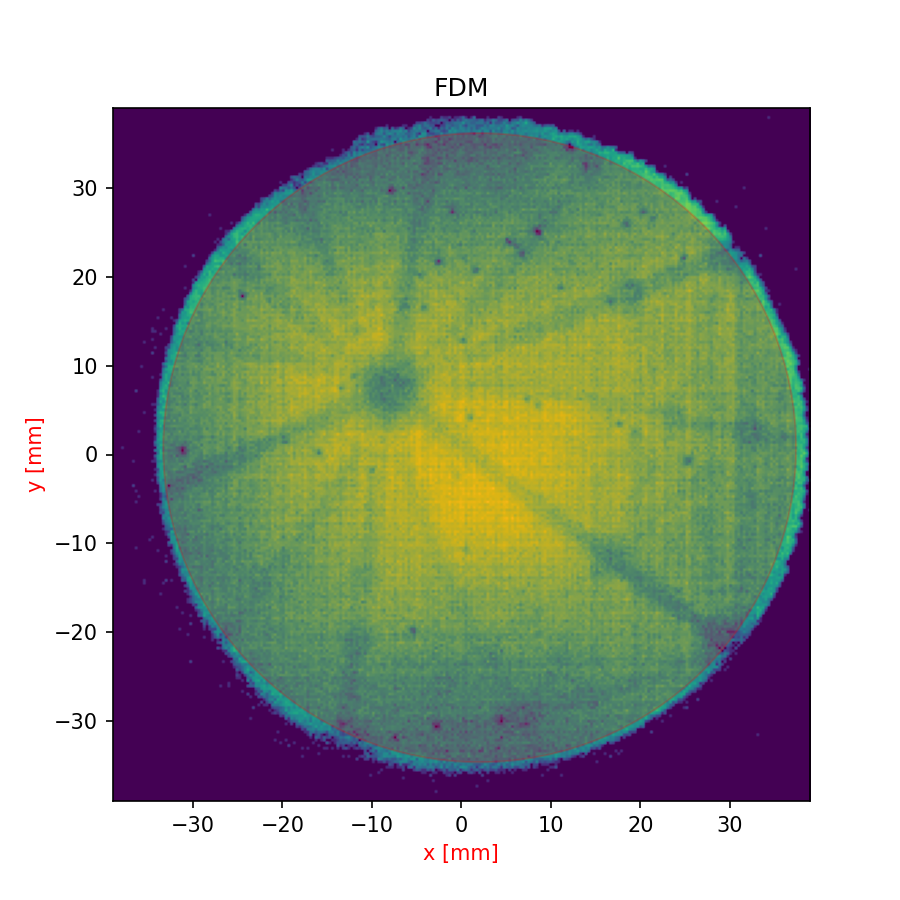

10-20-2022 13:00:20 | INFO | Circle selector Called
10-20-2022 13:00:20 | INFO | Circle selector Called
10-20-2022 13:00:20 | INFO | Circle selector Called
x: 2.04506120455995 y: 0.7714240522710725 roi: 35.37910204081632
10-20-2022 13:00:20 | INFO | Plot saved by the name C:\Users\mehrp\PycharmProjects\pyccapt\tests/results/load_crop/OLO_AL_6_data//FDM_c_OLO_AL_6_data
10-20-2022 13:00:20 | INFO | Plot saved by the name C:\Users\mehrp\PycharmProjects\pyccapt\tests/results/load_crop/OLO_AL_6_data//FDM_c_OLO_AL_6_data
10-20-2022 13:00:20 | INFO | Plot saved by the name C:\Users\mehrp\PycharmProjects\pyccapt\tests/results/load_crop/OLO_AL_6_data//FDM_c_OLO_AL_6_data


In [12]:
# plot selected area in FDM
fig1, ax1 = plt.subplots(figsize=(6,6))
data_loadcrop.plot_FDM_after_selection(ax1, fig1, data_crop, bins=(256,256), save_name = variables.result_path + '//FDM_c_' + dataset_name)

$\text {The final selected data after processing is shown below.}$

<IPython.core.display.Javascript object>


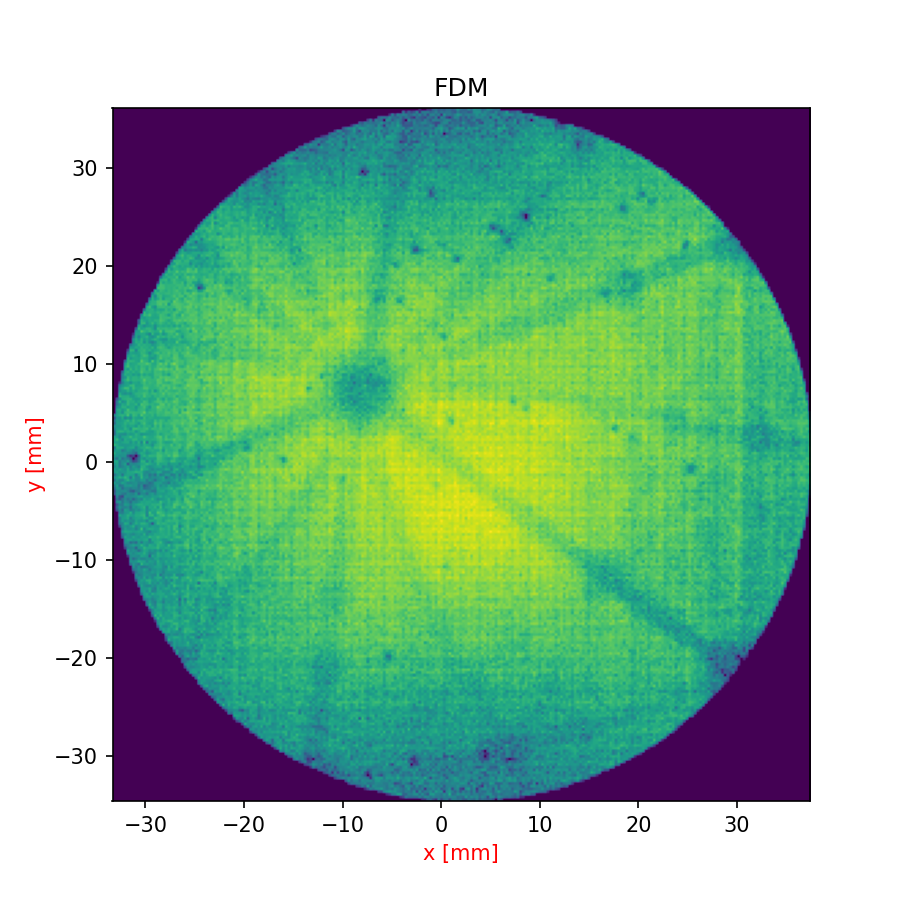

10-20-2022 13:00:24 | INFO | Plot saved by the name C:\Users\mehrp\PycharmProjects\pyccapt\tests/results/load_crop/OLO_AL_6_data//FDM_crop_OLO_AL_6_data
10-20-2022 13:00:24 | INFO | Plot saved by the name C:\Users\mehrp\PycharmProjects\pyccapt\tests/results/load_crop/OLO_AL_6_data//FDM_crop_OLO_AL_6_data
10-20-2022 13:00:24 | INFO | Plot saved by the name C:\Users\mehrp\PycharmProjects\pyccapt\tests/results/load_crop/OLO_AL_6_data//FDM_crop_OLO_AL_6_data


In [13]:
# Crop and plot the dataset
fig1, ax1 = plt.subplots(figsize=(6,6))
data_crop_FDM = data_loadcrop.crop_data_after_selection(data_crop)
data_loadcrop.plot_FDM(ax1, fig1, data_crop_FDM, bins=(256,256), save_name = variables.result_path + '//FDM_crop_' + dataset_name)

In [18]:
dld_masterDataframe

,values,values,values,values,values,values
0,500.000000,500.000000,11367,3746.360808,-25.310204,25.373878
1,501.897491,501.897491,29203,2564.370792,14.231020,19.579592
2,503.034485,503.034485,44265,2048.793210,25.819592,-19.261224
3,503.034485,503.034485,47099,3220.811694,17.414694,20.916735
4,503.034485,503.034485,47416,1394.704602,0.509388,28.780408
...,...,...,...,...,...,...
2000201,5710.397949,5710.397949,57835,611.363268,-11.493061,-17.255510
2000202,5710.397949,5710.397949,57889,602.125542,3.756735,-14.644898
2000203,5710.397949,5710.397949,58516,604.745298,2.260408,-17.733061
2000204,5710.397949,5710.397949,59519,613.502964,-22.540408,-0.923265


In [31]:
counter = data_crop_FDM[:, 2]
import numpy as np

In [73]:
pulse_pi = np.zeros(len(counter))
ion_pp = np.zeros(len(counter))
temp = counter[0]
multi_hit_count = 1
pulse_to_previous_ion = 0
for i in range(len(counter)):
    if i+2 > len(counter):
        ion_pp[i] = multi_hit_count
        pulse_pi[i] = counter[i] - counter[i-1]
        print(i)
        print( counter[i], counter[i-1])
    else:
        if temp == counter[i+1]:
            multi_hit_count = multi_hit_count + 1
        else:
            if i != 0:
                pulse_to_previous_ion = counter[i+1] - temp
            else:
                pulse_to_previous_ion = 0
            for j in range(multi_hit_count):
                if j == 0:
                    ion_pp[i+j] = multi_hit_count
                    pulse_pi[i+j] = pulse_to_previous_ion
                elif j != 0 or i == 0:
                    ion_pp[i+j] = 0
                    pulse_pi[i+j] = 0
            multi_hit_count = 1
            temp = counter[i+1]

#     print(pulse_pi)
#     print(ion_pp)
    

1929825
40388.0 40371.0


In [74]:
counter.shape

(1929826,)

In [70]:
ion_pp

array([1., 1., 1., ..., 1., 1., 1.])

In [71]:
pulse_pi

array([ 0.000e+00,  4.600e+01, -5.909e+04, ...,  1.040e+02,  1.700e+01,
        1.700e+01])

$\text {The final dataset is saved and the percentage of loss in TOF croption is prited.}$

In [ ]:
# save the dataset to hdf5 file
name = os.path.splitext(filename)[0]
data_loadcrop.save_croppped_data_to_hdf5(data_crop_FDM, dld_masterDataframe, savename, tdc_model)

In [ ]:
# add the dataset to hdf5 file
data_loadcrop.add_croppped_data_to_hdf5(filename, data_crop_FDM, dld_masterDataframe, tdc_model)